In [1]:
import sys
import os

sys.path.append(os.path.abspath('src'))

In [2]:
from model.labels_manager import LabelsManager

labels_manager = LabelsManager()

In [3]:
%%capture
# labels_manager.save_labels_to_csv()

In [4]:
from labels_printer import LabelsPrinter

labels_printer = LabelsPrinter(labels_manager)

c:\Users\justi\Documents\PROJETS\TAAC_project\src\labels_printer.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


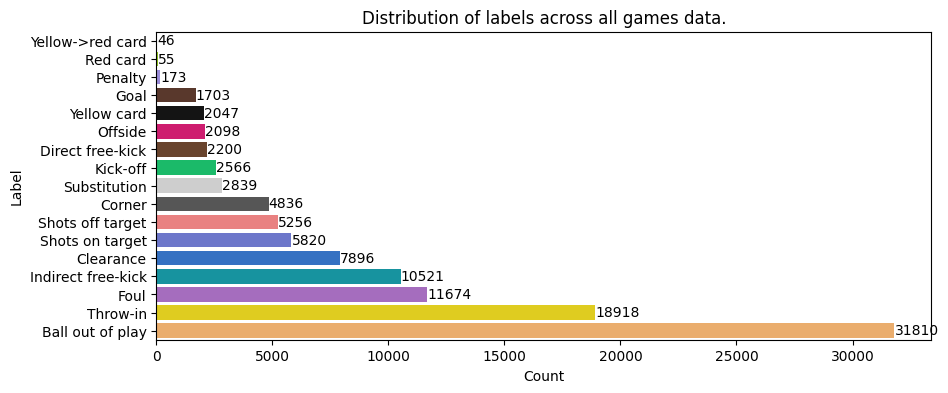

In [5]:
labels_printer.print_labels_distribution(fig_size=(10,4))

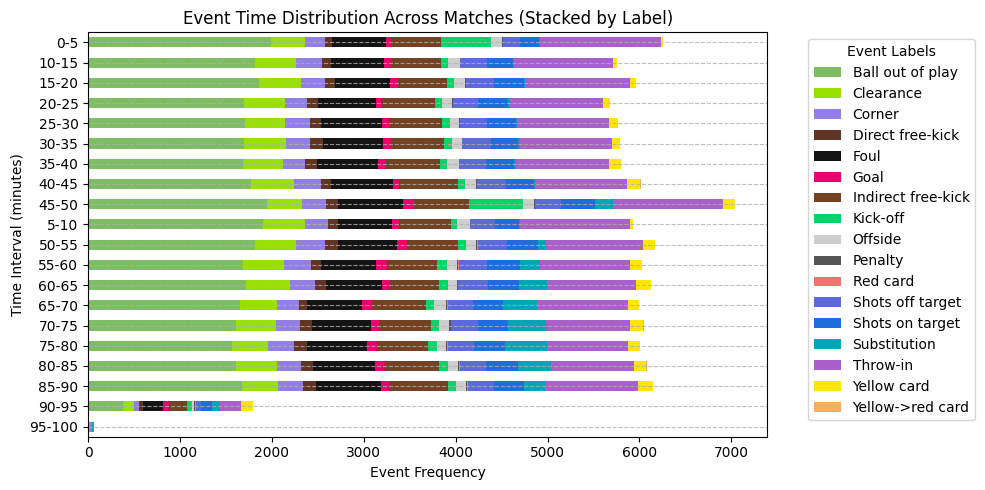

In [6]:
labels_printer.print_labels_distribution_over_game_intervals(fig_size=(10,5))

In [8]:
from model.data_loading import DataLoading

batch_size = 32
fps = 2
chunk_length = 60

train_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="train", context_aware=False)
val_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="valid", context_aware=False)

train_loader = train_dataloading.get_dataloader()
val_loader = val_dataloading.get_dataloader()


ImportError: cannot import name 'get_labels' from 'model.labels_manager' (c:\Users\justi\Documents\PROJETS\TAAC_project\src\model\labels_manager.py)

In [ ]:
import torch
from torch.utils.data import DataLoader
from context_aware_loss import TemporalSegmentationLoss
import model
import numpy as np

from training import Trainer

classifier = model.Model(input_dim=512, num_classes=17)


In [ ]:
trainer = Trainer(classifier, train_loader, val_loader, epochs=200, batch_size=batch_size, prediction_threshold=0.5, context_aware=False)
trainer.load_checkpoint("weights/model_0_2.pth")

In [ ]:
trainer.train()

In [ ]:
trainer.plot_training_loss()
trainer.save_checkpoint("weights/model_0_3.pth")

In [ ]:
from event_spotting import EventSpotter

test_dataloading = DataLoading("SoccerNet", 1, chunk_length=1, batch_size=1, split_type="test")

In [ ]:
video_name = test_dataloading.video_names[0]

features, labels = test_dataloading.load_features_labels(video_name, half=1)

print(features.shape)
print(labels.shape)

print(features[:5])
print(labels[:5])

event_spotter = EventSpotter(model=classifier, fps=fps, detection_threshold=0.7, nms_window=60, delta=360)

event_spotter.detect_events(features)

raw_predictions = event_spotter.get_predictions()
final_events = event_spotter.get_events()

ground_truth = {i: labels[i] for i in range(len(labels))}  # Format ground truth
print(f"Ground truth: {ground_truth}")
evaluation = event_spotter.evaluate_predictions(ground_truth)

print("Raw Predictions:", raw_predictions)
print("Final Detected Events:", final_events)
print("Evaluation Metrics:", evaluation)

event_spotter.show_predictions_summary(ground_truth, True)

In [ ]:
# Downloading the videos of the 500 games
# mySoccerNetDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train","valid","test","challenge"])

In [ ]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 20)
pd.set_option('display.colheader_justify', 'center')

annotations_df = labels_manager.parse_labels_json()
annotations_engineered_df = labels_manager.get_annotations_dataframe()

display(annotations_df.head())
annotations_df.to_csv("annotations.csv", index=False)

display(annotations_engineered_df.head(100))
annotations_engineered_df.to_csv("annotations_engineered.csv", index=False)

In [ ]:
print("Number of rows:", annotations_engineered_df.shape[0])
print("Number of columns:", annotations_engineered_df.shape[1])

In [ ]:
print("DataFrame Info:")
print(annotations_engineered_df.info())

In [ ]:
print("Missing Values per Column:")
print(annotations_engineered_df.isnull().sum())


In [ ]:
print("Descriptive Statistics (Including Non-Numerical):")
display(annotations_engineered_df.describe(include='all'))

In [ ]:
# Number of unique labels (excluding game-related columns)
label_columns = [col for col in annotations_engineered_df.columns if col.startswith('label_')]
unique_labels = len(label_columns)
print("Number of unique labels:", unique_labels)

# List of unique labels (based on the column names)
print("Unique labels:", label_columns)


In [ ]:
labels_manager.print_labels_distribution(annotations_engineered_df)

In [ ]:
labels_manager.print_labels_frequency(annotations_engineered_df)

In [ ]:
labels_manager.print_labels_frequency_per_league(annotations_engineered_df)

In [ ]:
labels_manager.print_labels_distribution_over_game_intervals(annotations_engineered_df)

NameError: name 'labels_manager' is not defined